# Decision Trees for Regression

## Setup

In [ ]:
#@title [Imports]
import numpy as np
import pandas as pd
from pprint import pprint
import os
import io
import warnings

#to amke this notebook's output stable across runs
np.random.seed(42)

#sklearn datasets
from sklearn.datasets import fetch_california_housing

#sklearn metrics for classification
from sklearn.metrics import log_loss
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve, plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve

#sklearn metrics for regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score


#sklearn for model_selection
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, GridSearchCV, ShuffleSplit
from sklearn.model_selection import validation_curve


#sklearn pre-processing
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder

#sklearn pipeline
from sklearn.pipeline import make_pipeline, Pipeline

#sklearn compose module
from sklearn.compose import ColumnTransformer

#sklearn impute module
from sklearn.impute import SimpleImputer

#sklearn dummy
# from sklearn.dummy import DummyClassifier

#sklearn linear model
# from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegression

#sklearn tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier

from sklearn import tree
from sklearn.tree import export_text

#scipy
from scipy.stats import loguniform

#To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

# #global settings
# mpl.rc('axes',labelsize=14)
# mpl.rc('xtick',labelsize=12)
# mpl.rc('ytick',labelsize=12)
# mpl.rc('figure',figsize=(8,6))

In [ ]:
np.random.seed(306)

Let's used `ShiffleSplit` as cv with 10 splits and 20% examples set aside as test examples

In [ ]:
cv= ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

## Load the dataset

In [ ]:
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)

#train-test split
com_train_features, test_features, com_train_labels, test_labels = train_test_split(
    features, labels, random_state=42)

#train--> train+dev split
train_features, dev_features, train_labels, dev_labels = train_test_split(
    com_train_features, com_train_labels, random_state=42
)



## Model Setup

In [ ]:
dt_reg_pipeline= Pipeline([('feature_scaling',StandardScaler()),('dt_reg', DecisionTreeRegressor(max_depth=3, random_state=42))])
dt_reg_cv_results= cross_validate(dt_reg_pipeline,
                                  com_train_features,
                                  com_train_labels,
                                  cv=cv,
                                  scoring='neg_mean_absolute_error',
                                  return_train_score=True,
                                  return_estimator=True)
dt_reg_train_error = -1*dt_reg_cv_results['train_score']
dt_reg_test_error = -1*dt_reg_cv_results['test_score']
print(f"Mean absolute error of linear regression model on the train set:\n" 
      f"{dt_reg_train_error.mean():.3f} +/- {dt_reg_train_error.std():.3f}")
print(f"Mean absolute error of linear regression model on the test set:\n" 
      f"{dt_reg_test_error.mean():.3f} +/- {dt_reg_test_error.std():.3f}")

Mean absolute error of linear regression model on the train set:
0.590 +/- 0.005
Mean absolute error of linear regression model on the test set:
0.593 +/- 0.007


## Visualizing the Tree

### 1. As tree diagram

In [ ]:
dt_reg_pipeline.fit(train_features, train_labels)

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('dt_reg',
                 DecisionTreeRegressor(max_depth=3, random_state=42))])

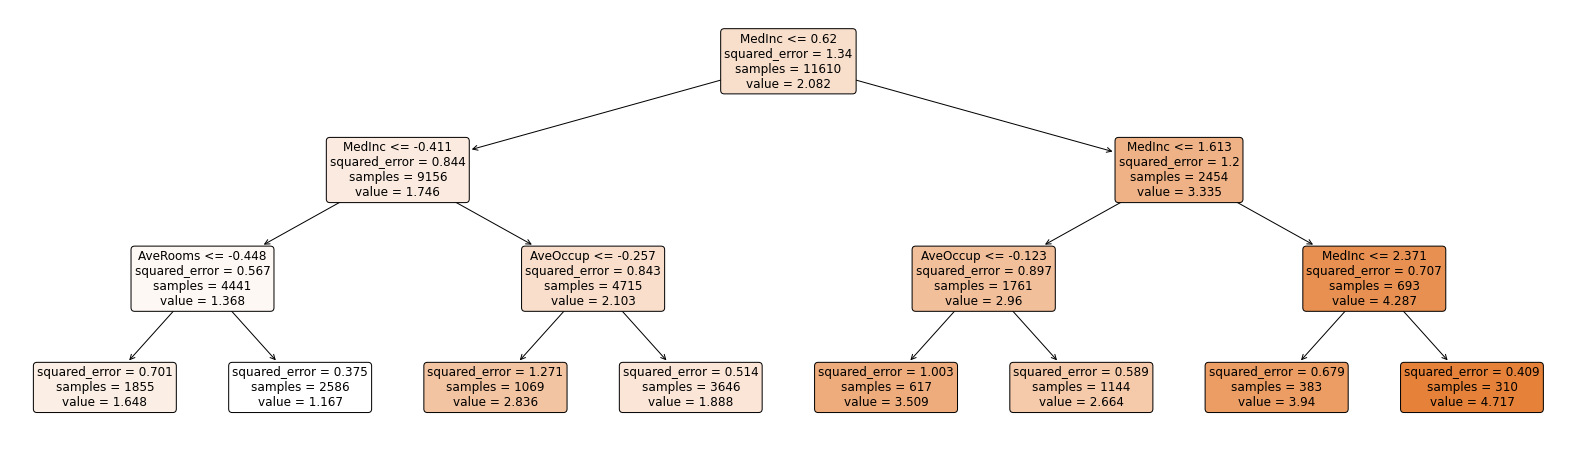

In [ ]:
plt.figure(figsize=(28,8), facecolor='w')
#create tree plot
a= tree.plot_tree(dt_reg_pipeline[-1],
                  feature_names=features.columns,
                  rounded=True,
                  filled=True,
                  fontsize=12)
plt.show()

### 2. As text-baseed diagram

In [ ]:
#export the decusion rules
tree_rules = export_text(dt_reg_pipeline[-1])
#print the result
print(tree_rules)

|--- feature_0 <= 0.62
|   |--- feature_0 <= -0.41
|   |   |--- feature_2 <= -0.45
|   |   |   |--- value: [1.65]
|   |   |--- feature_2 >  -0.45
|   |   |   |--- value: [1.17]
|   |--- feature_0 >  -0.41
|   |   |--- feature_5 <= -0.26
|   |   |   |--- value: [2.84]
|   |   |--- feature_5 >  -0.26
|   |   |   |--- value: [1.89]
|--- feature_0 >  0.62
|   |--- feature_0 <= 1.61
|   |   |--- feature_5 <= -0.12
|   |   |   |--- value: [3.51]
|   |   |--- feature_5 >  -0.12
|   |   |   |--- value: [2.66]
|   |--- feature_0 >  1.61
|   |   |--- feature_0 <= 2.37
|   |   |   |--- value: [3.94]
|   |   |--- feature_0 >  2.37
|   |   |   |--- value: [4.72]



## Use the tree for prediction

In [ ]:
test_labels_pred = dt_reg_pipeline.predict(test_features)

## Evaluating the tree

In [ ]:
mae = mean_absolute_error(test_labels, test_labels_pred)
mse = mean_squared_error(test_labels, test_labels_pred)
r2 = r2_score(test_labels, test_labels_pred)

print("The model performance for testing set")
print("-----------------------------------")
print("MAE is: ", mae)
print("MSE is: ", mse)
print('R2 score is: ',r2)

The model performance for testing set
-----------------------------------
MAE is:  0.6005762942842664
MSE is:  0.6417557936098145
R2 score is:  0.5150037690483743


### Hyper parameter Tuning

In [ ]:
param_grid = {'dt_reg__max_depth':range(1,20),
              'dt_reg__min_samples_split': range(2,8)}
dt_grid_search = GridSearchCV(dt_reg_pipeline,
                              param_grid=param_grid,
                              n_jobs=2,
                              cv=cv,
                              scoring="neg_mean_absolute_error",
                              return_train_score=True)
dt_grid_search.fit(com_train_features, com_train_labels)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('feature_scaling', StandardScaler()),
                                       ('dt_reg',
                                        DecisionTreeRegressor(max_depth=3,
                                                              random_state=42))]),
             n_jobs=2,
             param_grid={'dt_reg__max_depth': range(1, 20),
                         'dt_reg__min_samples_split': range(2, 8)},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [ ]:
mean_train_error = -1*dt_grid_search.cv_results_['mean_train_score'][dt_grid_search.best_index_]
mean_test_error = -1*dt_grid_search.cv_results_['mean_test_score'][dt_grid_search.best_index_]
std_train_error = -1*dt_grid_search.cv_results_['std_train_score'][dt_grid_search.best_index_]
std_test_error = -1*dt_grid_search.cv_results_['std_test_score'][dt_grid_search.best_index_]

print(f"Best Mean absolute error of decision tree regression model on the train set:\n" 
      f"{mean_train_error:.3f} +/- {std_train_error:.3f}")
print(f"Best Mean absolute error of decision tree regression   model on the test set:\n" 
      f"{mean_test_error:.3f} +/- {std_test_error:.3f}")

Best Mean absolute error of decision tree regression model on the train set:
0.278 +/- -0.006
Best Mean absolute error of decision tree regression   model on the test set:
0.428 +/- -0.012


In [ ]:
print("Mean cross validated score of the best estimator is: ", -1*dt_grid_search.best_score_)

Mean cross validated score of the best estimator is:  0.4283313044233501


In [ ]:
print("The best parameter value is: ", dt_grid_search.best_params_)

The best parameter value is:  {'dt_reg__max_depth': 11, 'dt_reg__min_samples_split': 5}


### Retraining the model with best hyperparameter value

In [ ]:
dt_reg_pipeline.set_params(dt_reg__max_depth=11, dt_reg__min_samples_split=5).fit(
    com_train_features, com_train_labels
)

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('dt_reg',
                 DecisionTreeRegressor(max_depth=11, min_samples_split=5,
                                       random_state=42))])

In [ ]:
test_labels_pred = dt_reg_pipeline.predict(test_features)
mae = mean_absolute_error(test_labels, test_labels_pred)
mse = mean_squared_error(test_labels,test_labels_pred)
r2= r2_score(test_labels, test_labels_pred)

In [ ]:
print("The model performance for testing set")
print("-----------------------------------")
print("MAE is: ", mae)
print("MSE is: ", mse)
print('R2 score is: ',r2)

The model performance for testing set
-----------------------------------
MAE is:  0.4248952183820017
MSE is:  0.4154957726373763
R2 score is:  0.6859960039130073


# Decision Tree using pipeline

## Loading & exploring the dataset

In [ ]:
column_names = ['Sex', 'Length', 'Diameter','Height', 'Whole weight', 'Shucked weight','Viscara weight','Shell weight', 'Rings']
abalone_data= pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data',header=None, names=column_names)

In [ ]:
type(abalone_data)

pandas.core.frame.DataFrame

In [ ]:
abalone_data.shape

(4177, 9)

In [ ]:
abalone_data.head(10)

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscara weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
5,I,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8
6,F,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.330,20
7,F,0.545,0.425,0.125,0.7680,0.2940,0.1495,0.260,16
8,M,0.475,0.370,0.125,0.5095,0.2165,0.1125,0.165,9
9,F,0.550,0.440,0.150,0.8945,0.3145,0.1510,0.320,19


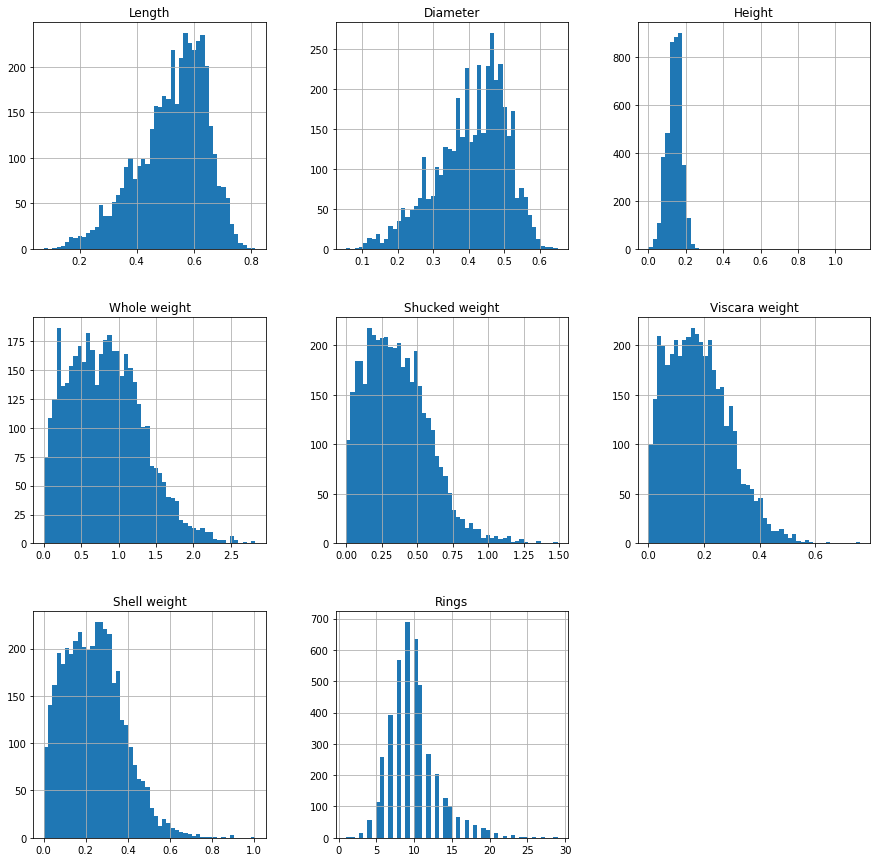

In [ ]:
abalone_data.hist(bins=50, figsize=(15,15))
#display histogram
plt.show()

<Figure size 432x288 with 0 Axes>

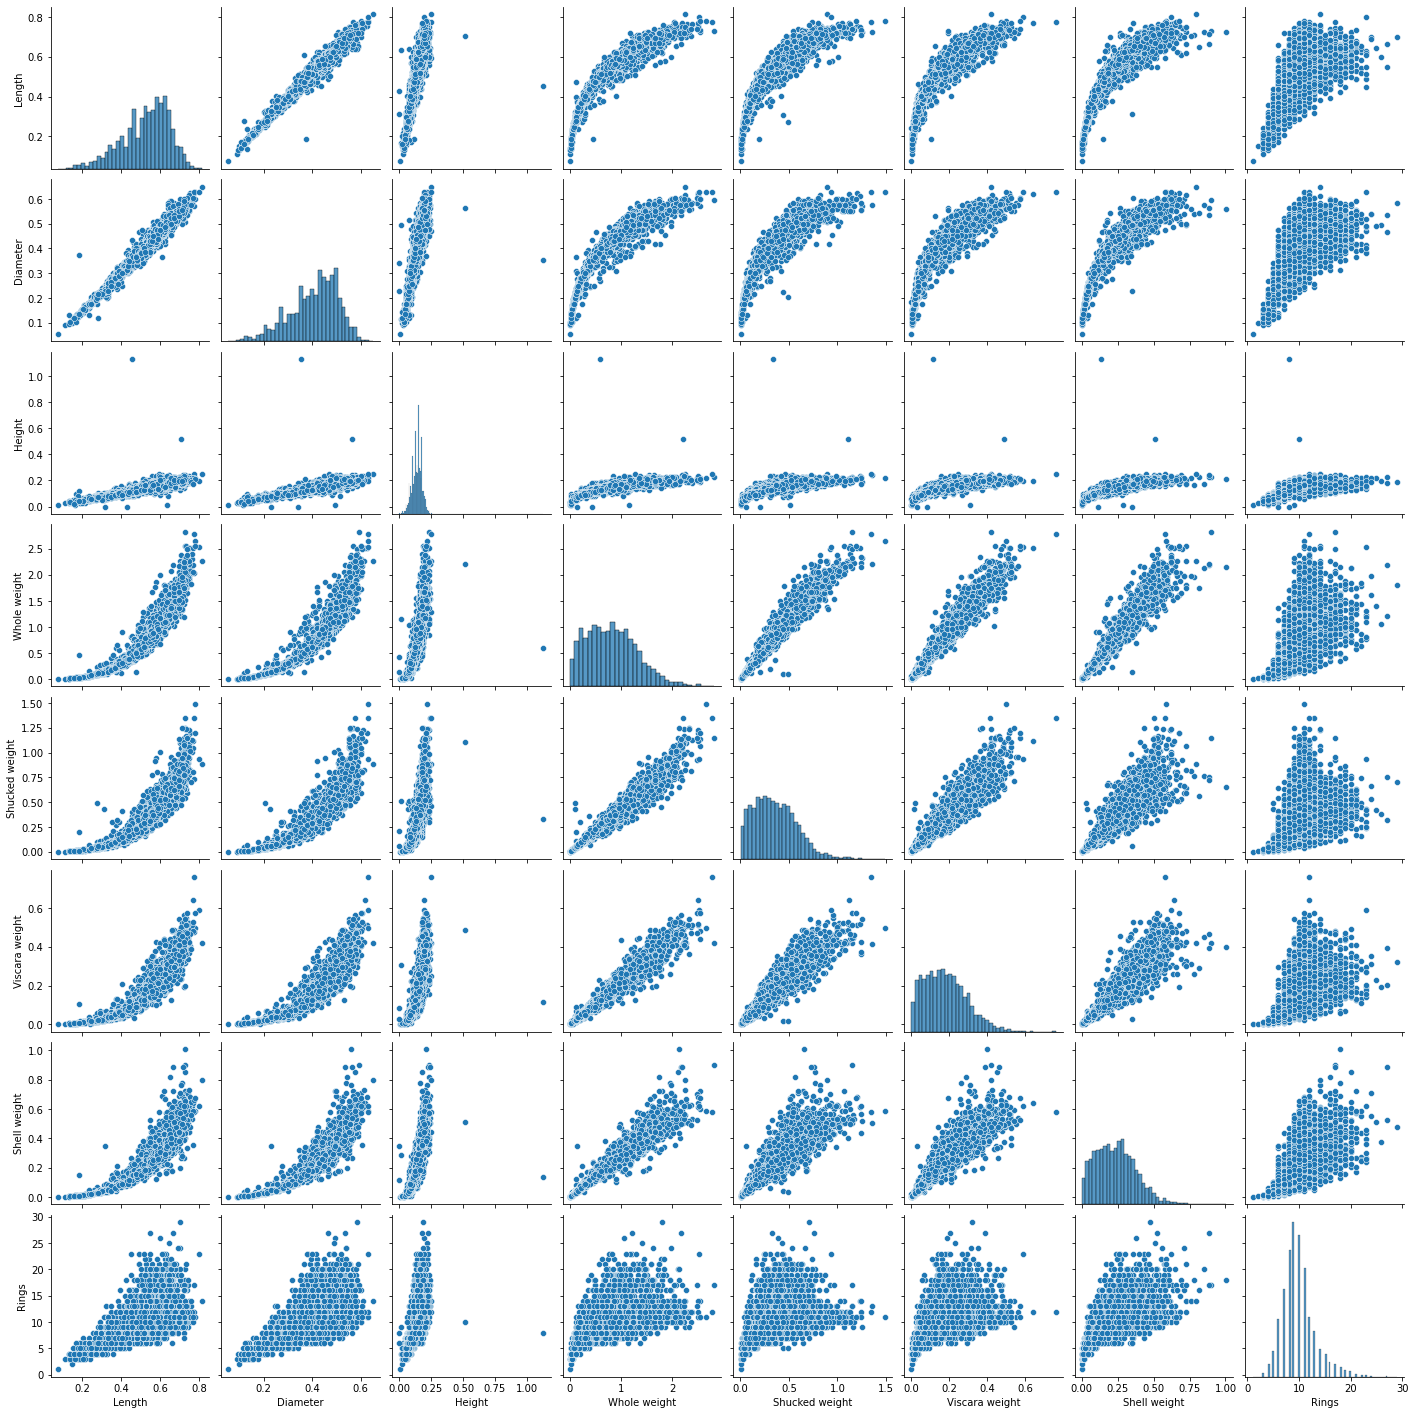

In [ ]:
plt.figure()
sns.pairplot(abalone_data,diag_kind='hist')
plt.show()

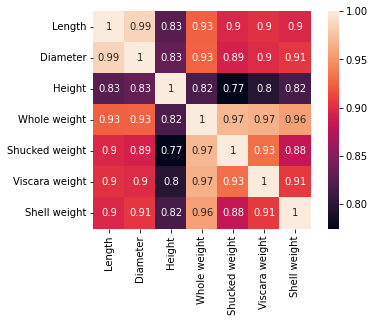

In [ ]:
plt.figure()
sns.heatmap(abalone_data.iloc[:,:-1].corr(),annot=True,square=True)
plt.show()

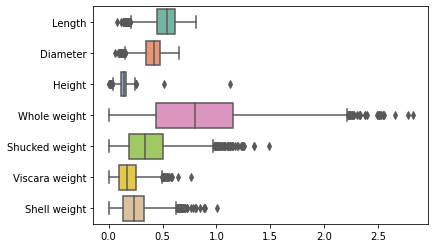

In [ ]:
plt.figure()
sns.boxplot(data=abalone_data.iloc[:,:-1],palette="Set2",orient="h")
plt.show()

In [ ]:
abalone_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscara weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [ ]:
abalone_data.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscara weight,Shell weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [ ]:
abalone_data['Rings'].unique()

array([15,  7,  9, 10,  8, 20, 16, 19, 14, 11, 12, 18, 13,  5,  4,  6, 21,
       17, 22,  1,  3, 26, 23, 29,  2, 27, 25, 24])

In [ ]:
abalone_data['Rings'].value_counts().sort_index()

1       1
2       1
3      15
4      57
5     115
6     259
7     391
8     568
9     689
10    634
11    487
12    267
13    203
14    126
15    103
16     67
17     58
18     42
19     32
20     26
21     14
22      6
23      9
24      2
25      1
26      1
27      2
29      1
Name: Rings, dtype: int64

We can see that target is 1 to 29( but there is no 28), so the classification we are going to do is a multi-class classification

## Preprocessing

### Missing values(0 values)

In [ ]:
(abalone_data['Height']==0).sum()

2

In [ ]:
abalone_data[abalone_data['Height']==0]

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscara weight,Shell weight,Rings
1257,I,0.430,0.34,0.0,0.428,0.2065,0.0860,0.1150,8
3996,I,0.315,0.23,0.0,0.134,0.0575,0.0285,0.3505,6


The number of missing values is 2 and is in the infant sex. Then we change the value 0 to null. we will fill the missing value with average Height faeture for the infant gender

In [ ]:
means = pd.pivot_table(abalone_data,index=['Sex'],aggfunc={'Height':np.mean})
means

,Height
Sex,
F,0.158011
I,0.107996
M,0.151381


### Storing data inform of X and y

In [ ]:
X=abalone_data.iloc[:,:-1]
y=abalone_data.iloc[:,-1]

In [ ]:
X[:5]

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscara weight,Shell weight
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055


### Splitting data into train and test sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)

## Pipelining

In [ ]:
numeric_features= ['Length', 'Diameter','Height', 'Whole weight', 'Shucked weight','Viscara weight','Shell weight']
categorical_features=['Sex']

In [ ]:
numeric_transformer = Pipeline(steps=[('imputer',SimpleImputer(missing_values=0,strategy='constant',fill_value=0.107996)),
                                      ('scaler',StandardScaler())])

In [ ]:
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

In [ ]:
preprocessor = ColumnTransformer(
    transformers = [
                   ('num',numeric_transformer,numeric_features),
                   ('cat',categorical_transformer,categorical_features)]
)

In [ ]:
clf = Pipeline([
                ('preprocessor',preprocessor),
                ('classifier',DecisionTreeClassifier(
                    max_depth=3, random_state=42
                ))])

In [ ]:
clf.fit(X_train,y_train)
print("model score: %.3f"%clf.score(X_test,y_test))

model score: 0.245


In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
comparison = np.concatenate((y_pred.reshape(len(y_pred),1),y_test.values.reshape(len(y_test),1)),1)
for each in comparison:
  print(each)

[10 13]
[8 8]
[10 11]
[4 5]
[10 12]
[10 11]
[9 7]
[8 8]
[7 7]
[10  9]
[7 8]
[5 8]
[ 9 11]
[8 9]
[5 4]
[10  7]
[9 7]
[10 17]
[10  7]
[7 7]
[7 7]
[7 5]
[8 8]
[9 9]
[10 10]
[10 10]
[4 5]
[11 15]
[ 8 10]
[10 14]
[9 8]
[4 4]
[10  9]
[11 13]
[7 7]
[8 7]
[7 8]
[10  9]
[7 8]
[10 11]
[ 8 15]
[ 8 12]
[ 8 17]
[10 16]
[10 11]
[ 8 11]
[9 8]
[10 10]
[10 11]
[7 6]
[10 13]
[7 7]
[ 9 13]
[11 20]
[ 8 12]
[9 7]
[5 8]
[ 9 10]
[7 7]
[7 7]
[10  9]
[9 9]
[ 9 11]
[7 8]
[7 7]
[11 12]
[11 13]
[10 17]
[8 8]
[11 12]
[8 9]
[11 17]
[10 10]
[8 6]
[ 8 11]
[8 8]
[10  8]
[8 9]
[10  8]
[8 8]
[10  8]
[5 6]
[7 7]
[10 13]
[ 8 11]
[7 6]
[10  9]
[11 12]
[4 5]
[7 6]
[ 9 11]
[ 8 11]
[9 8]
[7 7]
[10 16]
[5 8]
[ 8 11]
[9 8]
[10 18]
[10 11]
[10 12]
[ 8 14]
[10 12]
[10 11]
[5 6]
[10  9]
[7 7]
[7 6]
[ 7 11]
[10 11]
[11 11]
[11 12]
[ 8 20]
[ 9 10]
[10 14]
[11 10]
[10 10]
[10 12]
[5 4]
[ 8 12]
[7 7]
[10 13]
[7 6]
[8 8]
[10 17]
[10 15]
[10  9]
[10 11]
[7 7]
[10 11]
[10  8]
[9 7]
[8 7]
[10 10]
[11 11]
[10  9]
[ 8 10]
[8 9]
[7 8]
[11 16

In [ ]:
cm=confusion_matrix(y_test,y_pred)
print("Confusion matrix \n",cm)

Confusion matrix 
 [[ 0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  5  5  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  7 14  0 10  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1 12  0 28  4  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  3  0 56 13 22  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  3  0 25 43 28 13  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  7 47 24 47  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  4 22 17 49 15  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  2 20 14 45 14  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1 17  3 30 15  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  8  2 18 10  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 12  0 11  3  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  4  1  8  5  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  4  0  5  4  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


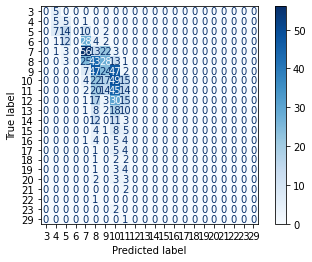

In [ ]:
plot_confusion_matrix(clf,X_test,y_test,cmap=plt.cm.Blues)
plt.show()

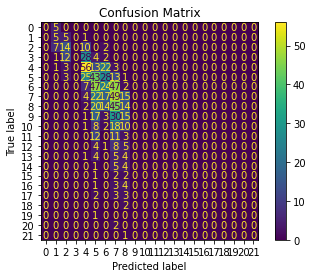

In [ ]:
y_test_predicted=clf.predict(X_test)
cm=confusion_matrix(y_test,y_test_predicted)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title('Confusion Matrix')

plt.show()

In [ ]:
CR=classification_report(y_test,y_pred)
print(CR)

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.26      0.45      0.33        11
           5       0.38      0.42      0.40        33
           6       0.00      0.00      0.00        47
           7       0.41      0.57      0.48        98
           8       0.21      0.38      0.27       113
           9       0.21      0.19      0.20       127
          10       0.20      0.46      0.28       107
          11       0.16      0.15      0.16        95
          12       0.00      0.00      0.00        66
          13       0.00      0.00      0.00        39
          14       0.00      0.00      0.00        26
          15       0.00      0.00      0.00        18
          16       0.00      0.00      0.00        14
          17       0.00      0.00      0.00        10
          18       0.00      0.00      0.00         5
          19       0.00      0.00      0.00         8
          20       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Cross-validation

In [ ]:
acc = cross_val_score(estimator=clf, X=X_train,y=y_train,cv=10)
print(type(acc))
print('Accuracy of each fold: ',list(acc*100))
print('Accuracy: {:.2f} %'.format(acc.mean()*100))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  UserWarning,


<class 'numpy.ndarray'>
Accuracy of each fold:  [27.46268656716418, 22.45508982035928, 23.952095808383234, 24.550898203592812, 24.251497005988025, 23.952095808383234, 25.449101796407188, 30.83832335329341, 26.34730538922156, 26.047904191616766]
Accuracy: 25.53 %


## Visualizing the tree

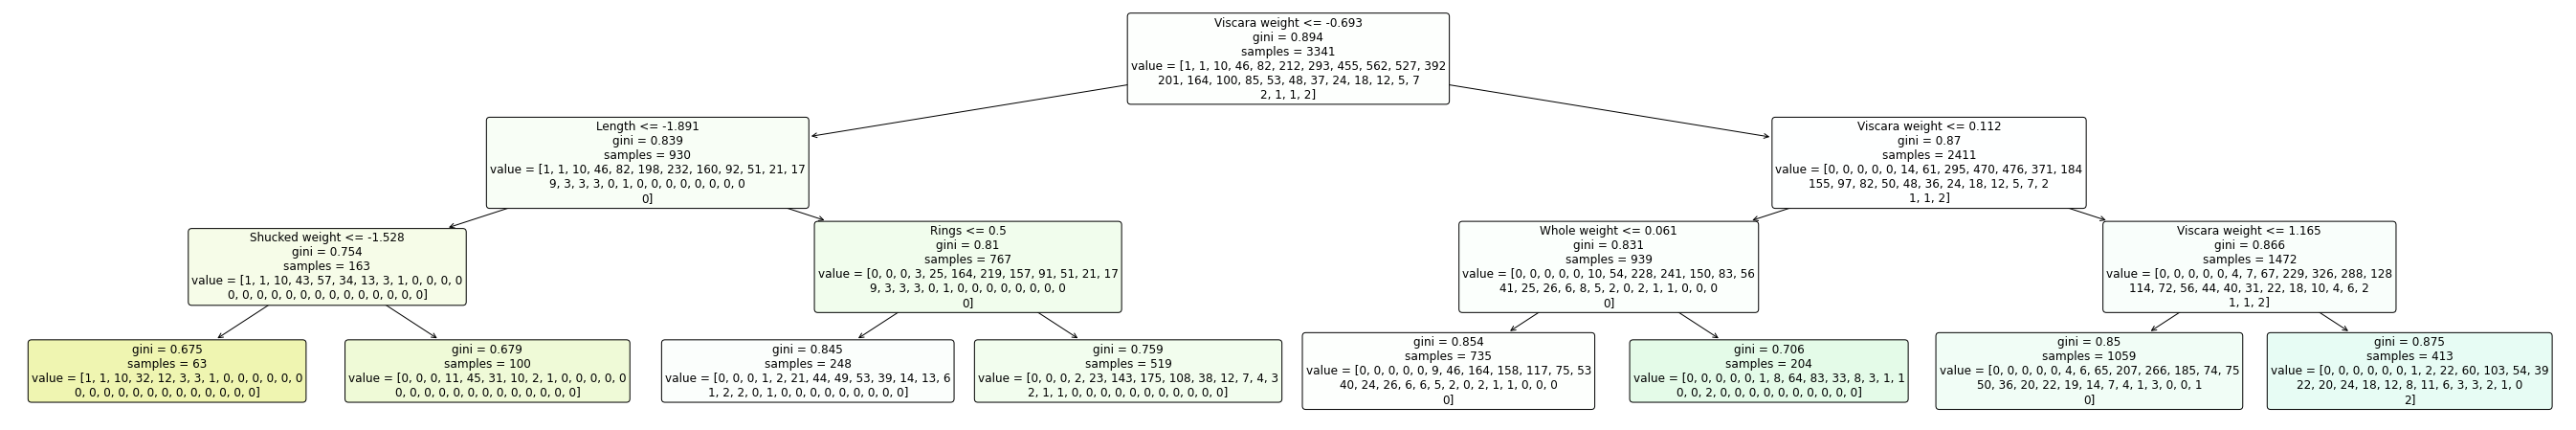

In [ ]:
plt.figure(figsize=(48,8),facecolor='w')

a=tree.plot_tree(clf['classifier'],
                 feature_names=column_names,
                 rounded=True,
                 filled=True,
                 fontsize=12)
plt.show()

## Finding the best parameters using GridSearchCV

In [ ]:
X_train_new = preprocessor.fit_transform(X_train)

In [ ]:
tuned_parameters = [{'max_depth':[1,2,3,4,5,6,7,8,9],
                     'min_samples_split':[2,4,6,8,10]}]
scores=['recall']
for score in scores:
  print()
  print(f"Tuning hyperparamters for {score}")
  print()

  clf_CV = GridSearchCV(DecisionTreeClassifier(),
                        tuned_parameters,
                        scoring=f'{score}_macro')
  clf_CV.fit(X_train_new, y_train)

  print("Best parameters:")
  print()
  print(clf_CV.best_params_)
  print()
  print("Grid Scores:")
  means = clf_CV.cv_results_["mean_test_score"]
  stds = clf_CV.cv_results_["std_test_score"]
  for mean, std, params in zip(means, stds, clf_CV.cv_results_['params']):
    print(f"{mean:0.3f}(+/-{std*2:0.03f}) for {params}")



Tuning hyperparamters for recall



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavio

Best parameters:

{'max_depth': 5, 'min_samples_split': 2}

Grid Scores:
0.073(+/-0.009) for {'max_depth': 1, 'min_samples_split': 2}
0.073(+/-0.009) for {'max_depth': 1, 'min_samples_split': 4}
0.073(+/-0.009) for {'max_depth': 1, 'min_samples_split': 6}
0.073(+/-0.009) for {'max_depth': 1, 'min_samples_split': 8}
0.073(+/-0.009) for {'max_depth': 1, 'min_samples_split': 10}
0.107(+/-0.011) for {'max_depth': 2, 'min_samples_split': 2}
0.107(+/-0.011) for {'max_depth': 2, 'min_samples_split': 4}
0.107(+/-0.011) for {'max_depth': 2, 'min_samples_split': 6}
0.107(+/-0.011) for {'max_depth': 2, 'min_samples_split': 8}
0.107(+/-0.011) for {'max_depth': 2, 'min_samples_split': 10}
0.131(+/-0.012) for {'max_depth': 3, 'min_samples_split': 2}
0.131(+/-0.012) for {'max_depth': 3, 'min_samples_split': 4}
0.131(+/-0.012) for {'max_depth': 3, 'min_samples_split': 6}
0.131(+/-0.012) for {'max_depth': 3, 'min_samples_split': 8}
0.131(+/-0.012) for {'max_depth': 3, 'min_samples_split': 10}
0.134(+/-

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
clf2=Pipeline([('preprocessor',preprocessor),
               ('classifier', DecisionTreeClassifier(
                   max_depth=5, min_samples_split=4, random_state=42
               ))])

In [ ]:
clf2.fit(X_train, y_train)
print("model score: %.3f"%clf2.score(X_test, y_test))

model score: 0.272


# Decision Tees for IRIS Dataset

In [ ]:
from sklearn.datasets import load_iris

In [ ]:
features, labels = load_iris(return_X_y=True, as_frame=True)

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=42)

In [ ]:
dt_pipeline=Pipeline([('feature_scaling', MinMaxScaler()),
                      ('dt_classifier', DecisionTreeClassifier(
                          max_depth=3, random_state=42
                      ))])

In [ ]:
dt_pipeline.fit(train_features, train_labels)

Pipeline(steps=[('feature_scaling', MinMaxScaler()),
                ('dt_classifier',
                 DecisionTreeClassifier(max_depth=3, random_state=42))])

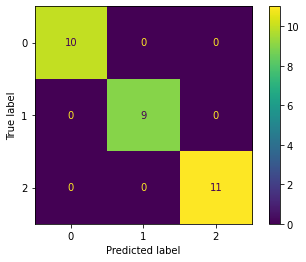

In [ ]:
ConfusionMatrixDisplay.from_estimator(dt_pipeline, test_features, test_labels)

In [ ]:
print(classification_report(test_labels, dt_pipeline.predict(test_features)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



## Visualize the trained tree

In [ ]:
data=load_iris()

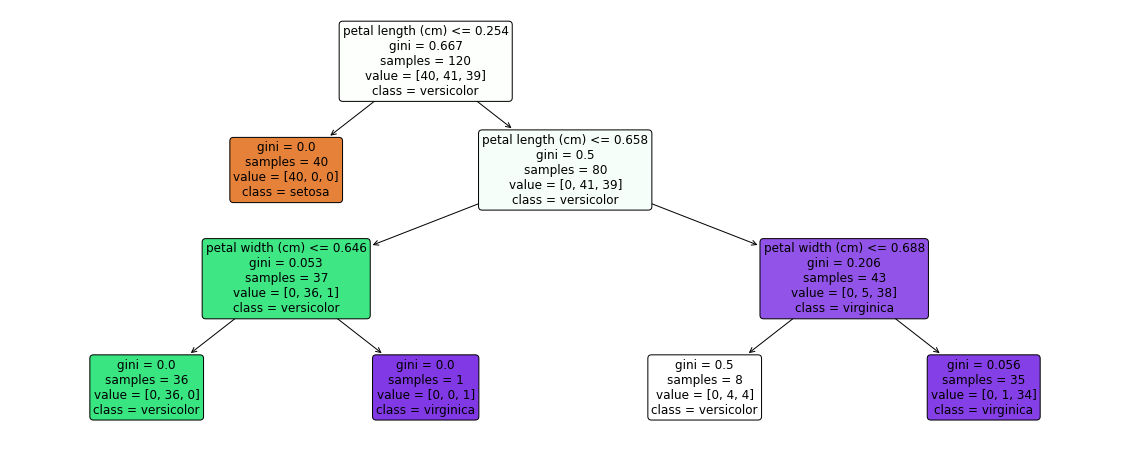

In [ ]:
plt.figure(figsize=(20,8),facecolor='w')

a=tree.plot_tree(dt_pipeline[-1],
                 feature_names=features.columns,
                 class_names=data.target_names,
                 rounded=True,
                 filled=True,
                 fontsize=12)
plt.show()

In [ ]:
tree_rules=export_text(dt_pipeline[-1],
                       feature_names=list(features.columns))
print(tree_rules)

|--- petal length (cm) <= 0.25
|   |--- class: 0
|--- petal length (cm) >  0.25
|   |--- petal length (cm) <= 0.66
|   |   |--- petal width (cm) <= 0.65
|   |   |   |--- class: 1
|   |   |--- petal width (cm) >  0.65
|   |   |   |--- class: 2
|   |--- petal length (cm) >  0.66
|   |   |--- petal width (cm) <= 0.69
|   |   |   |--- class: 1
|   |   |--- petal width (cm) >  0.69
|   |   |   |--- class: 2



## Feature Importance



In [ ]:
importance = pd.DataFrame({'feature':features.columns,
                           'importance':np.round(
                               dt_pipeline[-1].feature_importances_,3
                           )})
importance.sort_values('importance',ascending=False, inplace=True)
print(importance)

             feature  importance
2  petal length (cm)       0.935
3   petal width (cm)       0.065
0  sepal length (cm)       0.000
1   sepal width (cm)       0.000


## GridSearch

In [ ]:
hp_grid = [{'dt_classifier__max_depth':[1,2,3,4,5,6,7,8,9],
                     'dt_classifier__min_samples_split':[2,4,6,8,10]}]

gs_clf= GridSearchCV(dt_pipeline,
                        hp_grid,
                        scoring='f1_macro')
gs_clf.fit(train_features, train_labels)

print("Best parameters:")
print()
print(gs_clf.best_params_)
print()
print("Grid Scores:")
means = gs_clf.cv_results_["mean_test_score"]
stds = gs_clf.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, gs_clf.cv_results_['params']):
  print(f"{mean:0.3f}(+/-{std*2:0.03f}) for {params}")

Best parameters:

{'dt_classifier__max_depth': 4, 'dt_classifier__min_samples_split': 2}

Grid Scores:
0.559(+/-0.014) for {'dt_classifier__max_depth': 1, 'dt_classifier__min_samples_split': 2}
0.559(+/-0.014) for {'dt_classifier__max_depth': 1, 'dt_classifier__min_samples_split': 4}
0.559(+/-0.014) for {'dt_classifier__max_depth': 1, 'dt_classifier__min_samples_split': 6}
0.559(+/-0.014) for {'dt_classifier__max_depth': 1, 'dt_classifier__min_samples_split': 8}
0.559(+/-0.014) for {'dt_classifier__max_depth': 1, 'dt_classifier__min_samples_split': 10}
0.916(+/-0.091) for {'dt_classifier__max_depth': 2, 'dt_classifier__min_samples_split': 2}
0.916(+/-0.091) for {'dt_classifier__max_depth': 2, 'dt_classifier__min_samples_split': 4}
0.916(+/-0.091) for {'dt_classifier__max_depth': 2, 'dt_classifier__min_samples_split': 6}
0.916(+/-0.091) for {'dt_classifier__max_depth': 2, 'dt_classifier__min_samples_split': 8}
0.916(+/-0.091) for {'dt_classifier__max_depth': 2, 'dt_classifier__min_sampl

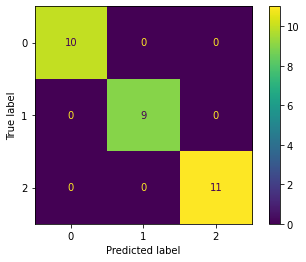

In [ ]:
ConfusionMatrixDisplay.from_estimator(gs_clf.best_estimator_,test_features,test_labels)